# Variational Quantum Linear Solver (VQLS) with Linear Combination of Unitaries (LCU) Block Encoding 

The Variational Quantum Linear Solver (VQLS) is a quantum algorithm that harnesses the power of Variational Quantum Eigensolvers (VQE) to solve systems of linear equations efficiently:

* **Input:** A matrix $\textbf{A}$ and a known vector $|\textbf{b}\rangle$.

* **Output:** An approximation of a normalized solution  $|x\rangle$ proportional to $|\textbf{x}\rangle$, satisfying the equation $\textbf{A} |\textbf{x}\rangle = |\textbf{b}\rangle$.

***


While the output of VQLS mirrors that of the HHL Quantum Linear-Solving Algorithm, VQLS distinguishes itself by its ability to operate on Noisy Intermediate-Scale Quantum (NISQ) computers. In contrast, HHL necessitates more robust quantum hardware and a larger qubit count, despite offering a faster computation speedup.

This tutorial covers an implementation example of a **Variational Quantum Linear Solver** [[1](#VQLS)] using block encoding. In particular, we use linear combinations of unitaries (LCUs) for the block encoding.

As with all variational algorithms, the VQLS is a hybrid algorithm in which we apply a classical optimization on the results of a parametrized (ansatz) quantum program.

## Building the Algorithm with Classiq

### Quantum Part: Variational Circuit

Given a block encoding of the matrix A:
$$\begin{aligned}
U = \begin{bmatrix} A & \cdot \\ \cdot & \cdot \end{bmatrix}
\end{aligned} \tag{1}$$  
we can prepare the state 
$$|\Psi\rangle :=  A |x\rangle/\sqrt{\langle x |A^\dagger A |x\rangle}.$$


We can approximate the solution $|x\rangle$ with a variational quantum
circuit, i.e., a unitary circuit $V$, depending on a finite number of classical real parameters $w = (w_0, w_1, \dots)$:

$$|x \rangle = V(w) |0\rangle.$$


Our objective is to address the task of preparing a quantum state $|x\rangle$ such that $A |x\rangle$ is proportional to $|b\rangle$; or, equivalently, ensuring that

$$|\Psi\rangle :=  \frac{A |x\rangle}{\sqrt{\langle x |A^\dagger A |x\rangle}} \approx |b\rangle.$$

The state $|b\rangle$ arises from a unitary operation $U_b$ applied to the ground state of $n$ qubits; i.e.,

$$|b\rangle = U_b |0\rangle.$$

To maximize the overlap between the quantum states $|\Psi\rangle$ and $|b\rangle$, we optimize the parameters, defining a cost function:

$$C = 1- |\langle b | \Psi \rangle|^2.$$


At a high level, the above could be implemented as follows:

We construct a quantum model as depicted in the figure below. When measuring the circuit in the computational basis, the probability of
finding the system qubits in the ground state (given the ancillary qubits measured
in their ground state) is
    $|\langle 0 | U_b^\dagger |\Psi \rangle|^2 = |\langle b | \Psi \rangle|^2.$

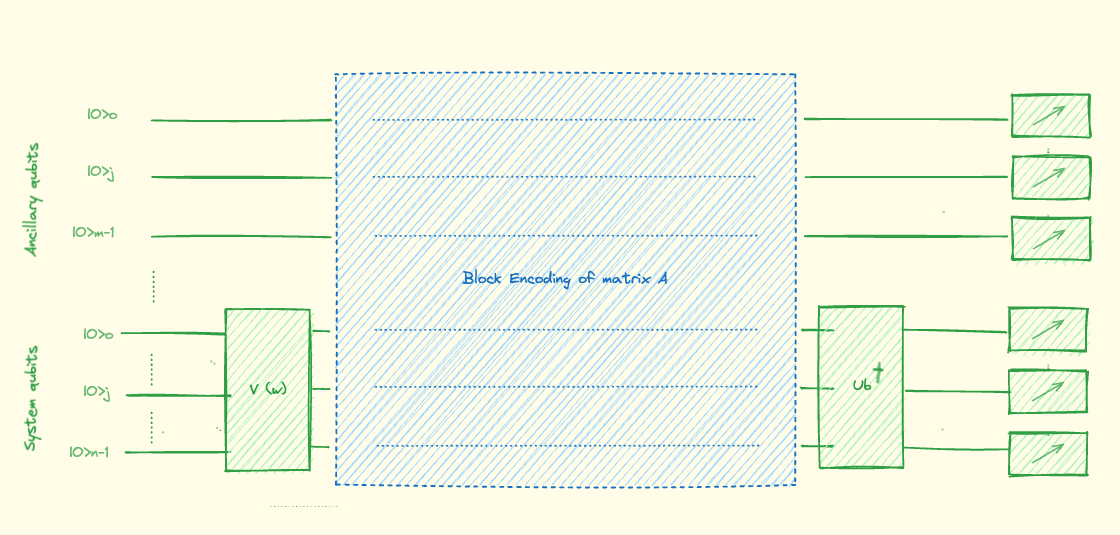



To block encode a Variational Quantum Linear Solver as explained above, we can define a high-level `block_encoding_vqls` function as follows:

In [2]:
from typing import List

import numpy as np

from classiq import *

In [3]:
@qfunc
def block_encoding_vqls(
    ansatz: QCallable,
    block_encoding: QCallable,
    prepare_b_state: QCallable,
) -> None:
    ansatz()
    block_encoding()
    invert(lambda: prepare_b_state())

From here, we only need to define `ansatz`, `block_encoding`, and `prepare_b_state` to fit the specific example above. Now we are ready to build our model, synthesize it, execute it, and analyze the results.

### Classical Part: Finding Optimal Parameters

To estimate the overlap of the ground state with the post-selected
state, we could directly make use of the measurement samples. However,
since we want to optimize the cost function, it is useful to express
everything in terms of expectation values through Bayes\' theorem:

$$|\langle b | \Psi \rangle|^2=
P( \mathrm{sys}=\mathrm{ground}\,|\, \mathrm{anc} = \mathrm{ground}) =
P( \mathrm{all}=\mathrm{ground})/P( \mathrm{anc}=\mathrm{ground})$$

To evaluate the conditional probability from the above equation, we construct the following utility function to operate on the measurement results:



To variationally solve our linear problem, we define the
cost function $C = 1- |\langle b | \Psi \rangle|^2$ that we are going to
minimize. As explained above, we express it in terms of expectation
values through Bayes\' theorem.

We define a classical function that gets the quantum program, minimizes the cost function using the COBYLA optimizer, and returns the optimal parameters.

In [4]:
import random

import matplotlib.pyplot as plt
from scipy.optimize import minimize


class VqlsOptimizer:
    def __init__(
        self, qprog, ansatz_param_count, ansatz_var_name, aux_var_name, exe_prefs=None
    ):
        self.qprog = qprog
        self.ansatz_param_count = ansatz_param_count
        self.ansatz_var_name = ansatz_var_name
        self.aux_var_name = aux_var_name
        if exe_prefs is None:
            self.es = ExecutionSession(qprog)
        else:
            self.es = ExecutionSession(qprog, exe_prefs)
        self.intermediate = {}

    def get_cond_prop(self, res):
        aux_prob_0 = 0
        all_prob_0 = 0
        for s in res:
            if s.state[self.aux_var_name] == 0:
                aux_prob_0 += s.shots
                if s.state[self.ansatz_var_name] == 0:
                    all_prob_0 = s.shots
        return all_prob_0 / aux_prob_0

    def my_cost(self, params):
        results = self.es.sample(params)
        return 1 - self.get_cond_prop(
            results.parsed_counts_of_outputs([self.ansatz_var_name, self.aux_var_name])
        )

    def f(self, x):
        cost = self.my_cost(
            {"params_" + str(k): x[k] for k in range(self.ansatz_param_count)}
        )
        self.intermediate[tuple(x)] = cost
        return cost

    def optimize(self):
        random.seed(1000)
        self._out = out = minimize(
            self.f,
            x0=[
                float(random.randint(0, 3000)) / 1000
                for i in range(0, self.ansatz_param_count)
            ],
            method="COBYLA",
            options={"maxiter": 2000},
        )
        print(out)
        self._out_f = out_f = [out["x"][0 : self.ansatz_param_count]]
        print(out_f)
        plt.plot(
            [l for l in range(len(self.intermediate))], list(self.intermediate.values())
        )

        return {
            "params_" + str(k): list(self.intermediate.keys())[-1][k]
            for k in range(self.ansatz_param_count)
        }

***
Once the optimal variational weights `w` are found, we
can generate the quantum state $|x\rangle$. By measuring $|x\rangle$ in
the computational basis we can estimate the probability of each basis
state.
***

## Example Using LCU Block Encoding

We treat a specific example based on a system of three qubits:

$$\begin{aligned}
\begin{align}
A  &=  c_0 A_0 + c_1 A_1 + c_2 A_2 = \ 0.55 \mathbb{I} \ + \ 0.225 Z_1 \ + \ 0.225 Z_2
\\
\\
|b\rangle &= U_b |0 \rangle = H_0  H_1  H_2 |0\rangle,
\end{align}
\end{aligned}$$

where $Z_j, X_j, H_j$ represent the Pauli $Z$, Pauli $X$, and Hadamard
gates applied to the qubit with index $j$.

To block encode the matrix A we use the LCU method. This can be done with the `lcu_paulis` library function. Note that this function can get a unnormalized Pauli operator, thus we calculate the normalization factor for the post-process analysis.
The LCU quantum circuit looks as follows:
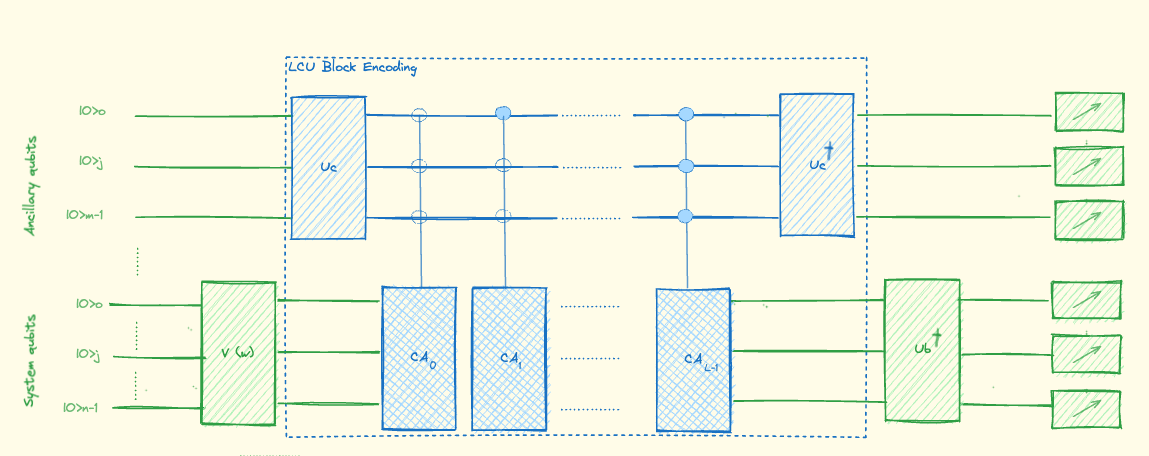

In [5]:
pauli_terms_structs = (
    0.55 * Pauli.I(0)
    + 0.225 * Pauli.I(0) * Pauli.Z(1) * Pauli.I(2)
    + 0.225 * Pauli.I(0) * Pauli.I(1) * Pauli.Z(2)
)
normalization = sum([p.coefficient for p in pauli_terms_structs.terms])

num_system_qubits = pauli_terms_structs.num_qubits
num_ancila_qubits = (len(pauli_terms_structs.terms) - 1).bit_length()
ansatz_param_count = 9

### Fixed Hardware Ansatz

Let's consider our ansatz $V(w)$, such that 

$$|x\rangle = V(w) |0\rangle.$$


This allows us to "search" the state space by varying a set of parameters, $w$. 

The ansatz that we use for this three-qubit system implementation takes in nine parameters as defined in the `apply_fixed_3_qubit_system_ansatz` function:

In [6]:
@qfunc
def apply_ry_on_all(params: CArray[CReal], io: QArray[QBit]):
    repeat(count=io.len, iteration=lambda index: RY(params[index], io[index]))


@qfunc
def apply_fixed_3_qubit_system_ansatz(
    angles: CArray[CReal], system_qubits: QArray[QBit]
):
    apply_ry_on_all([angles[0], angles[1], angles[2]], system_qubits)
    repeat(
        count=(system_qubits.len - 1),
        iteration=lambda index: CZ(system_qubits[0], system_qubits[index + 1]),
    )
    CZ(system_qubits[1], system_qubits[2])
    apply_ry_on_all([angles[3], angles[4], angles[5]], system_qubits)
    repeat(
        count=(system_qubits.len - 1),
        iteration=lambda index: CZ(
            system_qubits[system_qubits.len - 1], system_qubits[index]
        ),
    )
    CZ(system_qubits[1], system_qubits[0])
    apply_ry_on_all([angles[6], angles[7], angles[8]], system_qubits)

To view our ansatz implementation we create a model and view the synthesis result: 

In [7]:
@qfunc
def main(
    params: CArray[CReal, ansatz_param_count], system_qubits: Output[QArray[QBit]]
):
    allocate(3, system_qubits)
    apply_fixed_3_qubit_system_ansatz(params, system_qubits)


qprog_1 = synthesize(main)
show(qprog_1)

Quantum program link: https://platform.classiq.io/circuit/32pWjH6oUwpzhB9OZFVtHUvCXBA


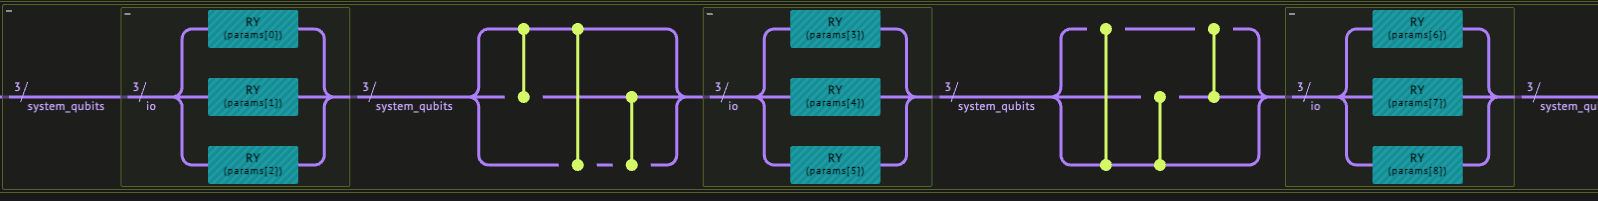

This is called a **fixed hardware ansatz** in that the configuration of quantum gates remains the same for each run of the circuit, and all that changes are the parameters. Unlike the QAOA ansatz, it is not composed solely of Trotterized Hamiltonians. The applications of $Ry$ gates allow us to search the state space, while the $CZ$ gates create "interference" between the different qubit states.

### Running the VQLS

Now, we can define the main function: we call `block_encoding_vqls` with the arguments of our specific example.

In [8]:
@qfunc
def main(
    params: CArray[CReal, ansatz_param_count],
    ancillary_qubits: Output[QNum[num_ancila_qubits]],
    system_qubits: Output[QNum[num_system_qubits]],
):

    allocate(ancillary_qubits)
    allocate(system_qubits)

    block_encoding_vqls(
        ansatz=lambda: apply_fixed_3_qubit_system_ansatz(params, system_qubits),
        block_encoding=lambda: lcu_pauli(
            operator=pauli_terms_structs, data=system_qubits, block=ancillary_qubits
        ),
        prepare_b_state=lambda: apply_to_all(H, system_qubits),
    )

Constructing the model, synthesizing, and executing on the Classiq simulator:

In [9]:
qprog_2 = synthesize(main)
show(qprog_2)

Quantum program link: https://platform.classiq.io/circuit/32pWkF7CG67svJGIRWJMZ0lqwcS


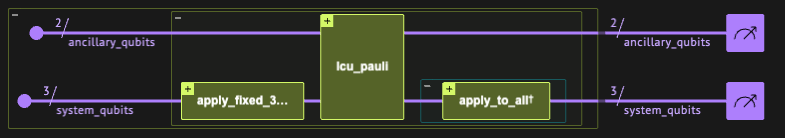

In [10]:
write_qmod(main, name="vqls_with_lcu", decimal_precision=15, symbolic_only=False)

We run the classical optimizer to get the optimal parameters:

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.09572291736048333
       x: [ 2.183e+00  3.097e+00  9.850e-01  2.482e+00  3.129e+00
            6.554e-01  1.201e+00  2.307e+00  9.622e-01]
    nfev: 100
   maxcv: 0.0
[array([2.18263061, 3.09658041, 0.98498817, 2.48189263, 3.12912539,
       0.65539631, 1.20116677, 2.30650636, 0.96216622])]


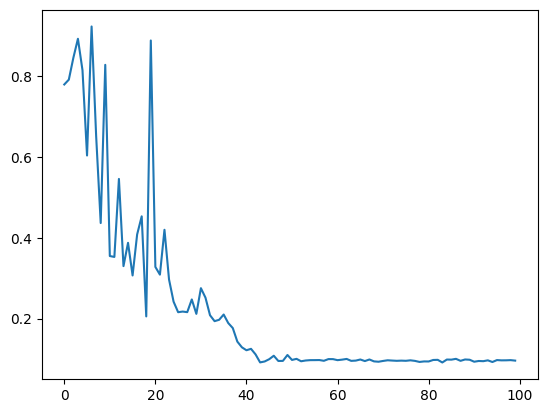

In [11]:
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
execution_preferences = ExecutionPreferences(
    num_shots=204800, backend_preferences=backend_preferences
)

optimizer = VqlsOptimizer(
    qprog_2,
    ansatz_param_count,
    "system_qubits",
    "ancillary_qubits",
    execution_preferences,
)
optimal_params = optimizer.optimize()

### Measuring the Quantum Solution

Finally, we can apply the optimal parameters to measure the quantum results for $\vec{x}$:

In [12]:
@qfunc
def main(io: Output[QNum[num_system_qubits]]):
    allocate(io)
    apply_fixed_3_qubit_system_ansatz(list(optimal_params.values()), io)


qprog_3 = synthesize(main)

In [13]:
with ExecutionSession(qprog_3, execution_preferences) as es:
    results = es.sample()

df = results.dataframe

In [14]:
amplitudes = np.zeros(2**num_system_qubits).astype(complex)
amplitudes[df.io] = df.amplitude
# Preprocessed quantum solution: we know the solution is real, and that the last point is positive
global_phase = np.angle(amplitudes[-1])
amplitudes = np.real(amplitudes / np.exp(1j * global_phase))
if (
    amplitudes[-1] < 0
):  # we can extract the solution up to a sign, align with the expected
    amplitudes *= -1
print(amplitudes)

[0.10545817 0.09824632 0.23525783 0.25226615 0.199245   0.30080137
 0.46216235 0.71865688]


In [15]:
probabilities = amplitudes**2

### Comparing to the Classical Solution

Since the specific problem considered in this tutorial has a small size,
we can also solve it in a classical way and then compare the results
with our quantum solution.

We use the explicit matrix representation in terms of numerical NumPy arrays.

Classical calculation:

In [16]:
A_num = pauli_operator_to_matrix(pauli_terms_structs) / normalization
b = np.ones(8) / np.sqrt(8)

Calculating the classical $\vec{x}$ that solves the equation:

In [17]:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)
classical_probs = np.real((x / np.linalg.norm(x))) ** 2
classical_probs

array([0.00464634, 0.00464634, 0.0153598 , 0.0153598 , 0.0153598 ,
       0.0153598 , 0.46463405, 0.46463405])

To compare the classical to the quantum results we compute the post-processing by applying $A$ to our optimal vector $|\psi\rangle_o$, normalizing it, then calculating the inner product squared of this vector and the solution vector, $|b\rangle$! We can put this all into code as follows:

In [18]:
print(
    "overlap =",
    (b.dot(A_num.dot(amplitudes) / (np.linalg.norm(A_num.dot(amplitudes))))) ** 2,
)

overlap = (0.9040151946512618+0j)


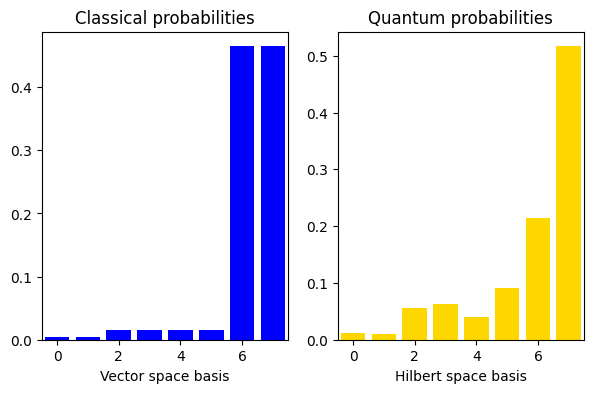

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2**num_system_qubits), classical_probs, color="blue")
ax1.set_xlim(-0.5, 2**num_system_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2**num_system_qubits), probabilities, color="gold")
ax2.set_xlim(-0.5, 2**num_system_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

The classical cost function basically agrees with the algorithm result.

## References

<a name='VQLS'>[1]</a>: [Bravo-Prieto et al.,Variational Quantum Linear Solver, 2020.](https://arxiv.org/pdf/1909.05820.pdf)


<a name='coherent'>[2]</a>: Robin Kothari. \"Efficient algorithms in quantum query complexity.\"
    PhD thesis, University of Waterloo, 2014.

